
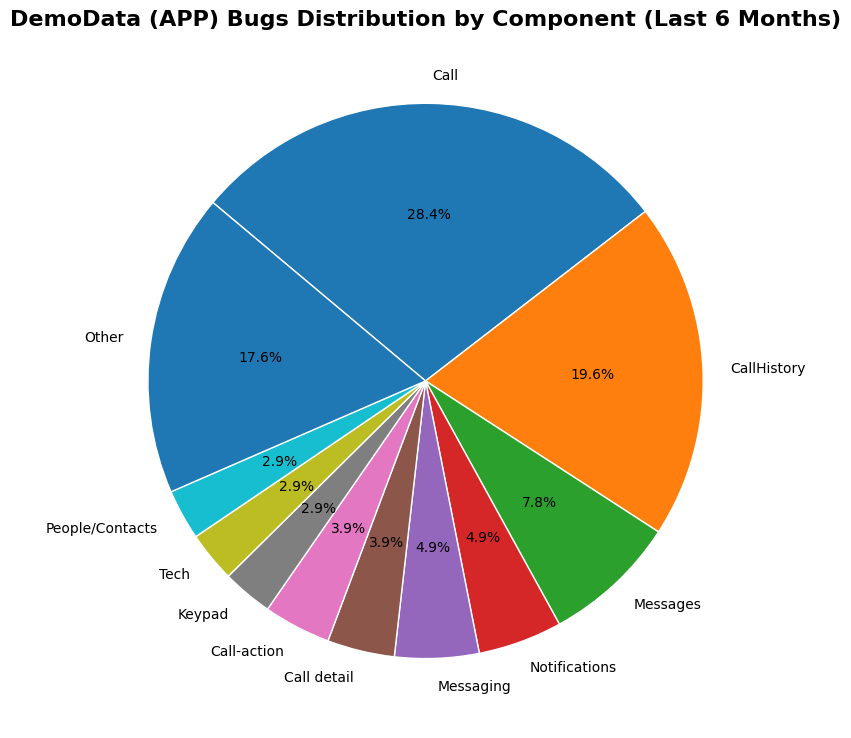

,🧩 Component,🐞 Bug Count,Risk Score,Explanation
0,Call,29,21,"The ""Call"" component has a very high history of bugs, making it high-risk."
1,CallHistory,20,20,"The ""CallHistory"" component has a moderate risk based on recent bug frequency."
2,Messages,8,19,"The ""Messages"" component has a moderate risk based on recent bug frequency."
3,Messaging,5,17,"The ""Messaging"" component has a moderate risk based on recent bug frequency."
4,Notifications,5,17,"The ""Notifications"" component has a moderate risk based on recent bug frequency."
5,Call detail,4,15,"The ""Call detail"" component has a moderate risk based on recent bug frequency."
6,Call-action,4,15,"The ""Call-action"" component has a moderate risk based on recent bug frequency."
7,Tech,3,11,"The ""Tech"" component has a moderate risk based on recent bug frequency."
8,Settings,3,11,"The ""Settings"" component has a moderate risk based on recent bug frequency."
9,People/Contacts,3,11,"The ""People/Contacts"" component has a moderate risk based on recent bug frequency."


In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
import io
import base64

project_name = "DemoData (APP)"

data = pd.read_csv('../data/processed/DemoData.csv')
# --- Prepare summary values ---
# Ensure 'Components' column exists and is not empty
report_title_html = f"""
<div style="background: #111; border-radius: 12px; padding: 18px 28px; margin-bottom: 24px; box-shadow: 0 2px 8px #222; text-align:center;">
    <h2 style="margin-top:0; color:#ffe066;">🔎 <b>Bug Risk Analysis: DemoData (APP)</b></h2>
    <p style="font-size: 1.5em; color: #fff; margin: 0 auto; display: inline-block; text-align: center;">
        Analyzing bug distribution and risk scores to spotlight the most vulnerable components.<br>
        <b>Data window:</b> Last 6 months<br>
        <b>Use:</b> Guide testing, triage, and resource allocation.
    </p>
</div>
"""
display(HTML(report_title_html))
# --- Date filtering ---
if 'Created' in data.columns:
    data['Created'] = pd.to_datetime(data['Created'], errors='coerce', utc=True)
    data['Created'] = data['Created'].dt.tz_localize(None)

if 'Created' in data.columns and 'Components' in data.columns and not data['Created'].isnull().all():
    last_month = data['Created'].max().to_period('M')
    last_6_months = pd.period_range(end=last_month, periods=6, freq='M').astype(str)
    data['Created_Month'] = data['Created'].dt.to_period('M').astype(str)
    data_last6 = data[data['Created_Month'].isin(last_6_months)]
else:
    data_last6 = data.copy()

# --- Explode components for accurate counting ---
exploded = data_last6[['key', 'Components']].dropna().copy()
exploded['Components'] = exploded['Components'].astype(str)
exploded = exploded.assign(
    Component=exploded['Components'].str.split(',')
).explode('Component')
exploded['Component'] = exploded['Component'].str.strip()

# --- Pie chart data ---
component_counts = exploded['Component'].value_counts()
top_n = 10
top_components = component_counts[:top_n]
other_count = component_counts[top_n:].sum()
if other_count > 0:
    top_components['Other'] = other_count

# --- Static pie chart (matplotlib, always visible in HTML export) ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    top_components,
    labels=top_components.index,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)
ax.set_title('DemoData (APP) Bugs Distribution by Component (Last 6 Months)', fontsize=16, fontweight='bold')
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight')
plt.close(fig)
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode('utf-8')
buf.close()
display(HTML(f"""
<div style="display: flex; flex-direction: column; align-items: center;">
    <img src="data:image/png;base64,{img_base64}" style="max-width:500px; height:auto; margin: 0 auto 32px auto;" />
</div>
"""))

# --- Summary values ---
total_bugs = data_last6['key'].nunique()
top_component = component_counts.idxmax()
top_count = component_counts.max()
top_bug_count = exploded[exploded['Component'] == top_component]['key'].nunique()

summary_html = f"""
<div style="background: #111; border-radius: 12px; padding: 18px 28px; margin-bottom: 24px; box-shadow: 0 2px 8px #222;">
    <h2 style="margin-top:0; color:#ffe066;">✨ <b>Risk Scoring Summary for {project_name}</b> ✨</h2>
    <ul style="font-size: 1.2em; color: #fff;">
        <li><b>Total bugs (last 6 months):</b> {total_bugs}</li>
        <li><b>Top risk component:</b> <span style="color:#ffd166;">{top_component}</span>
            ({top_count} occurrences in {top_bug_count} bugs)
        </li>
        <li><b>Scoring based on:</b> Created date in last 6 months</li>
    </ul>
</div>
"""
display(HTML(summary_html))

# --- Component-centric risk table ---
# ...existing code...

# Assign risk score: highest bug count = highest risk score
component_summary['Risk_Score'] = component_summary['Bug_Count'].rank(ascending=True, method='min').astype(int)
max_rank = component_summary['Risk_Score'].max()

def get_explanation(component, risk_score, max_rank):
    if risk_score == max_rank:
        return f'The "{component}" component has a very high history of bugs, making it high-risk.'
    elif risk_score <= 2:
        return f'The "{component}" component has a low history of bugs, making it low-risk.'
    else:
        return f'The "{component}" component has a moderate risk based on recent bug frequency.'

# Add Explanation column BEFORE taking top 10
component_summary['Explanation'] = [
    get_explanation(row['Component'], row['Risk_Score'], max_rank)
    for _, row in component_summary.iterrows()
]

# ...existing code...

# Take top 10 components by bug count for display
component_summary_top = component_summary.head(10)

# Find min and max risk score in the displayed table
min_risk = component_summary_top['Risk_Score'].min()
max_risk = component_summary_top['Risk_Score'].max()

# Style table with color for Risk Score
def color_risk(val):
    try:
        score = int(val)
        if score == max_risk:
            color = '#ff4d4d'  # Red for high risk
            text_color = 'white'
        elif score == min_risk:
            color = '#85e085'  # Green for low risk
            text_color = 'black'
        else:
            color = '#ffd966'  # Yellow for moderate risk
            text_color = 'black'
        return f'background-color: {color}; color: {text_color}; font-weight: bold;'
    except Exception:
        return ''

styled_summary = component_summary_top.rename(
    columns={'Component': '🧩 Component', 'Bug_Count': '🐞 Bug Count', 'Risk_Score': 'Risk Score'}
).style.set_properties(
    subset=['Explanation'],
    **{'white-space': 'pre-wrap', 'word-break': 'break-word', 'max-width': '400px'}
).map(color_risk, subset=['Risk Score']).set_table_styles([
    {'selector': 'th', 'props': [('background-color', "#1a1368"), ('color', 'white'), ('font-size', '1.1em')]}
])

display(HTML(f"""
<div style="display: flex; flex-direction: column; align-items: center;">
    <h3 style="text-align:center; color:#ffd166;">📊 <b>Top Components by Bug Count</b></h3>
    <div style="min-width:450px; max-width:900px;">
        {styled_summary.to_html(escape=False)}
    </div>
    <p style="color:#888; font-size:0.95em; margin-top:18px;">🔎 <i>Table shows top 10 components by unique bug count.</i></p>
</div>
"""))
# ...existing code...
# component_risk_table(data, "DemoData (APP)")